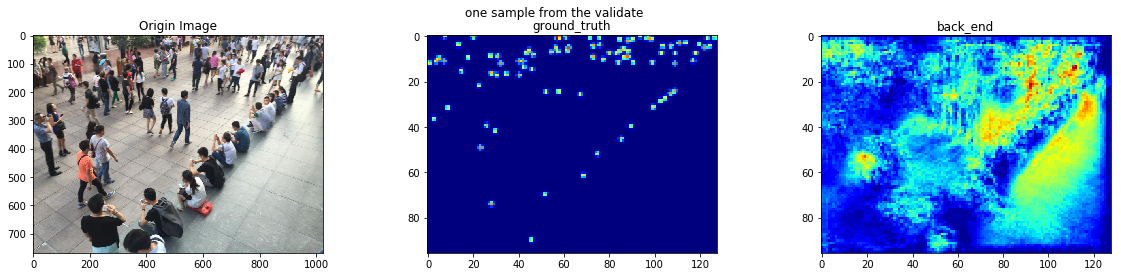

The gt counts of the above sample:86.66376495361328, and the pred counts:62.77729797363281
In step 0, epoch 1, with loss 9.971490859985352, MAE = 33.31458282470703, MSE = 44.9446907043457


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sys
import DME_deformable
import DME
import math
import random
%matplotlib inline
result_output = open("/home/zzn/SANet_implementation-master/result_B_12.13.txt", "w")
image_train_path = "/home/zzn/part_B_final/train_data/images_train.npy"
gt_train_path = "/home/zzn/part_B_final/train_data/gt_train.npy"
image_validate_path = "/home/zzn/part_B_final/train_data/images_validate.npy"
gt_validate_path = "/home/zzn/part_B_final/train_data/gt_validate.npy"
batch_size = 1
epoch = 500
MAE = 19970305
if __name__ == '__main__':
    image_train = np.load(image_train_path)
    gt_train = np.load(gt_train_path)
    image_validate = np.load(image_validate_path)
    gt_validate = np.load(gt_validate_path)

    x = tf.placeholder(tf.float32, shape=[None, None, None, 3], name="input")
    y = tf.placeholder(tf.float32, shape=[None, None, None, 1], name="label")
    estimated_density_map = DME_deformable.DME_model(x)
    # estimated_density_map = DME.DME_model(x)

    estimated_counting = tf.reduce_sum(estimated_density_map, reduction_indices=[1, 2, 3], name='estimated_counting')
    gt_counting = tf.cast(tf.reduce_sum(y, reduction_indices=[1, 2, 3], name='gt_counting'), tf.float32)

    sum_filter = tf.constant([1. for i in range(64)], dtype=tf.float32, shape=[8, 8, 1, 1])
    gt_map = tf.nn.conv2d(y, sum_filter, [1, 8, 8, 1], padding='SAME', name='gt_map')

    loss = tf.squeeze(
        tf.reduce_mean(
            tf.reduce_sum(
                tf.square(estimated_density_map - gt_map),
                reduction_indices=[1, 2, 3]),
            axis=0, name='loss')
        / 2)

    train_op = tf.train.AdamOptimizer(1e-5).minimize(loss=loss, global_step=tf.train.get_global_step())
    
    AE_batch = tf.abs(tf.subtract(estimated_counting, gt_counting))
    SE_batch = tf.square(tf.subtract(gt_counting, estimated_counting))

    saver = tf.train.Saver()
    with tf.Session() as sess:
        # init the Variables
        init_op = tf.global_variables_initializer()
        sess.run(init_op)
        image_train_num = len(image_train)
        step = 0
        for i in range(epoch):
            shuffle_batch = np.random.permutation(image_train_num // batch_size)
            for j in range(image_train_num // batch_size):

                # validate
                if step % 50 == 0:
                    loss_ = []
                    MAE_ = []
                    MSE_ = []
                    for k in range(len(image_validate // batch_size)):
#                         loss_eval, batch_average_error, batch_square_error, ed_map = sess.run([loss, AE_batch, SE_batch, estimated_density_map],feed_dict={x: image_validate[k:k + batch_size],y: gt_validate[k:k + batch_size]})
                        loss_eval, batch_average_error, batch_square_error, gt_validate_down_sampling_map, predict_den, gt_counts, pred_counts = sess.run(
                                [loss, AE_batch, SE_batch, gt_map, estimated_density_map, gt_counting, estimated_counting],
                                feed_dict={x: image_validate[k:k + batch_size], y: gt_validate[k:k + batch_size]})
                        loss_.append(loss_eval)
                        MAE_.append(batch_average_error)
                        MSE_.append(batch_square_error)
    
    
                    
                    loss_ = np.reshape(loss_, [-1])
                    MAE_ = np.reshape(MAE_, [-1])
                    MSE_ = np.reshape(MSE_, [-1])
                    # calculate the validate loss, validate MAE and validate RMSE
                    validate_loss = np.mean(loss_)
                    validate_MAE = np.mean(MAE_)
                    validate_RMSE = np.sqrt(np.mean(MSE_))
                    # show one of the validate samples
                    random_num = random.randint(0, 19)
                    gt_validate_down_sampling_map, predict_den, gt_counts, pred_counts = sess.run([gt_map, estimated_density_map, gt_counting, estimated_counting], feed_dict={x: image_validate[random_num:random_num+1], y: gt_validate[random_num:random_num+1]})
                    figure, (origin, density_gt, pred) = plt.subplots(1, 3, figsize=(20, 4))        
                    origin.imshow(image_validate[random_num])
                    origin.set_title('Origin Image')
                    density_gt.imshow(np.squeeze(gt_validate_down_sampling_map), cmap=plt.cm.jet)
                    density_gt.set_title('ground_truth')
                    predict_den = np.squeeze(predict_den)
                    pred.imshow(predict_den, cmap=plt.cm.jet)
                    pred.set_title('back_end')
                    plt.suptitle("one sample from the validate")
                    plt.show()
                    # show the validate MAE and MSE values on stdout
                    gt_counts = np.squeeze(gt_counts)
                    pred_counts = np.squeeze(pred_counts)
                    sys.stdout.write(
                        'The gt counts of the above sample:{}, and the pred counts:{}\n'.format(gt_counts, pred_counts))
                    sys.stdout.write(
                        'In step {}, epoch {}, with loss {}, MAE = {}, MSE = {}\n'.format(step, i + 1, validate_loss,
                                                                                          validate_MAE, validate_RMSE)) 
                    sys.stdout.flush()
                    # save model
                    if MAE > validate_MAE:
                        MAE = validate_MAE
                        saver.save(sess, './checkpoint_dir/MyModel_deformable')
#                 train
                start = (shuffle_batch[j] * batch_size) % image_train_num
                end = min(start + batch_size, image_train_num)
                sess.run(train_op, feed_dict={x: image_train[start:end], y: gt_train[start:end]})
                step = step + 1

